# Logistic Regression
We use logistic regression for binary classification - survival or deceased.

Titianic Data Set:

* survival:	0 = No, 1 = Yes
* pclass: Ticket class,	1 = 1st, 2 = 2nd, 3 = 3rd
* sex: Sex	
* Age: Age in years	
* sibsp: # of siblings / spouses aboard the Titanic	
* parch: # of parents / children aboard the Titanic	
* ticket: Ticket number	
* fare: Passenger fare	
* cabin: Cabin number	
* embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton


# Logistic regression formulation 

Given training data $S = \{(x_i, y_i): i =1,\ldots, n\}$ with $x_i \in \mathbb{R}^d$ and $y_i\in \{0, 1\}$, the logistic regression formulation in the linear case is given by 

 $$\large  \min_{\mathbf{w}, w_0}  \sum_{i=1}^n  \log \bigl(  1 +  \exp( (1-2 y_i) (\mathbf{w}^T x_i +  w_0)  )  \bigr) $$

After we learn $\mathbf{w}$ and $w_0$ from training data $S$, we make prediction on the test data according to 
$$\large P(  y =1 | x) =  {1\over 1+ \exp( - (\mathbf{w}^T x +  w_0) )}$$
$$\large P(  y =0 | x) =  {1\over 1+ \exp(\mathbf{w}^T x +  w_0 )}$$

## Import Libraries

In [155]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## The Data

Let's start by reading in the titanic_train.csv file into a pandas dataframe.

In [156]:
titanic = pd.read_csv('titanic.csv')
titanic.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [157]:
titanic.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Missing Data

We can use seaborn to create a simple heatmap to see where we are missing data!

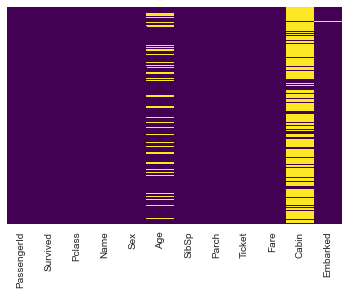

In [158]:
#print(titanic.isnull())
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Roughly 20 percent of the Age data is missing. The proportion of Age missing is likely small enough for reasonable replacement with imputation. Too much missing data in the Cabin column. We'll drop this column later.

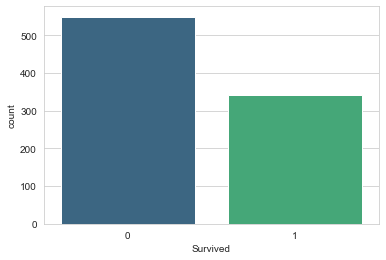

In [159]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',data=titanic,palette='viridis')

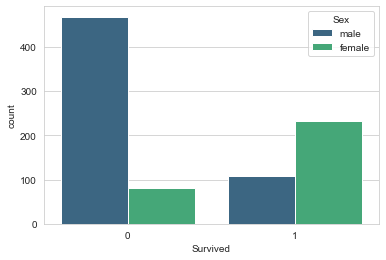

In [160]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=titanic,palette='viridis')

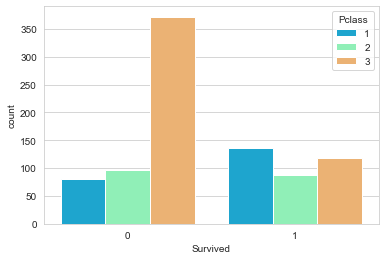

In [161]:
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Pclass',data=titanic,palette='rainbow')

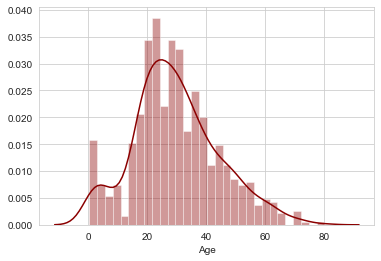

In [162]:
sns.distplot(titanic['Age'].dropna(),kde=True,color='darkred',bins=30)

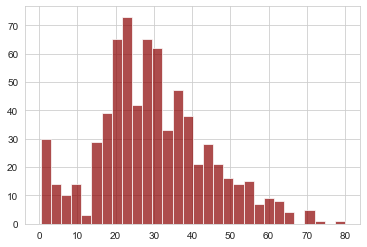

In [163]:
titanic['Age'].hist(bins=30,color='darkred',alpha=0.7)

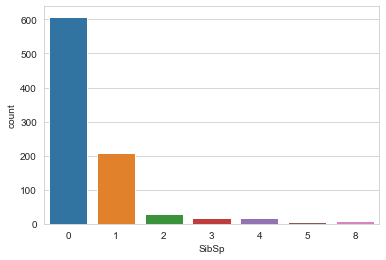

In [164]:
sns.countplot(x='SibSp',data=titanic)

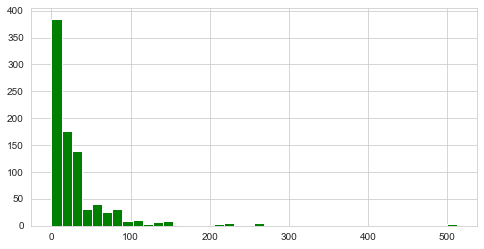

In [165]:
titanic['Fare'].hist(color='green',bins=40,figsize=(8,4))

### Cufflinks for plots

In [166]:
import cufflinks as cf
cf.go_offline()
titanic['Fare'].iplot(kind='hist',bins=200,color='green')

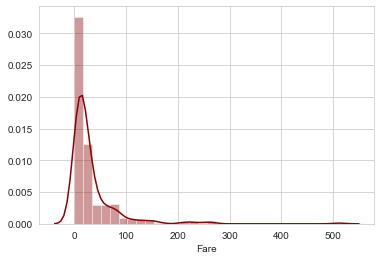

In [167]:
sns.distplot(titanic['Fare'],bins = 30,color='darkred')

___
## Data Cleaning
We want to fill in missing age data instead of just dropping the missing age data rows. One way to do this is by filling in the mean age of all the passengers (imputation).
However we can check the average age by passenger class:

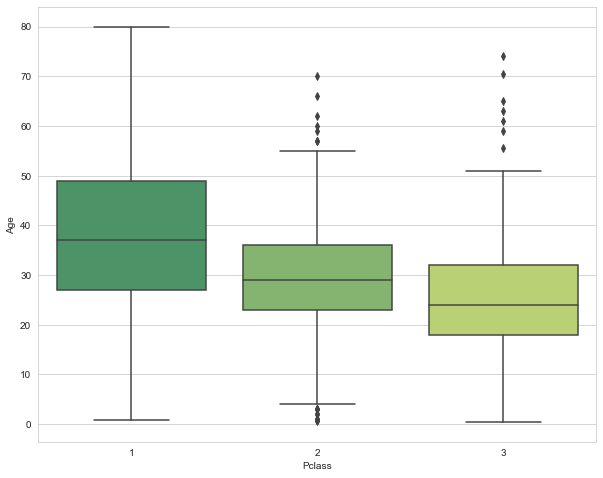

In [168]:
plt.figure(figsize=(10, 8))
sns.boxplot(x='Pclass',y='Age',data=titanic, palette='summer')

In [169]:
# calculate the mean of ages
agemean = np.zeros(3)
print(agemean)

for i in range(1,4):
    temp=titanic[ titanic['Pclass'] ==i ]['Age'].mean()
    agemean[i-1] = temp  
print(agemean)

[0. 0. 0.]
[38.23344086 29.87763006 25.14061972]


Wealthier passengers in the higher classes tend to be older, which makes sense. We'll use these average age values to impute based on Pclass for Age.

In [170]:
def impute_age(cols):
    Age = cols[0]
    Pclass = cols[1]
    
    if pd.isnull(Age):

        if Pclass == 1:
            return agemean[0]

        elif Pclass == 2:
            return agemean[1]

        else:
            return agemean[2]
    else:
        return Age

In [171]:
titanic['Age'] = titanic[['Age','Pclass']].apply(impute_age,axis =1)

Check that heat map again:

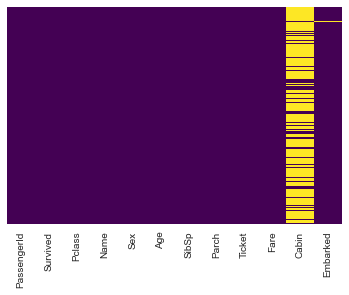

In [172]:
sns.heatmap(titanic.isnull(),yticklabels=False,cbar=False,cmap='viridis')

Drop the Cabin column and the row in Embarked that is NaN.

In [173]:
titanic.shape[0]  # check how many rows in the original data 
len(titanic)
titanic.drop('Cabin',axis=1,inplace=True)  # delete the column Cabin

In [174]:
titanic

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00000,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00000,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,25.14062,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00000,0,0,111369,30.0000,C


In [176]:
titanic.dropna(inplace=True) # drop rows with missing Embarked

titanic.shape[0]

889

## Converting Categorical Features 

We'll need to convert categorical features to dummy variables (taking value 1 (presence) and 0 (absence)) using pandas. Otherwise our machine learning algorithm won't be able to directly take in those features as inputs.

In [177]:
titanic.info()
titanic

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  889 non-null    int64  
 1   Survived     889 non-null    int64  
 2   Pclass       889 non-null    int64  
 3   Name         889 non-null    object 
 4   Sex          889 non-null    object 
 5   Age          889 non-null    float64
 6   SibSp        889 non-null    int64  
 7   Parch        889 non-null    int64  
 8   Ticket       889 non-null    object 
 9   Fare         889 non-null    float64
 10  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(4)
memory usage: 83.3+ KB


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.00000,1,0,A/5 21171,7.2500,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.00000,1,0,PC 17599,71.2833,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.00000,0,0,STON/O2. 3101282,7.9250,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.00000,1,0,113803,53.1000,S
4,5,0,3,"Allen, Mr. William Henry",male,35.00000,0,0,373450,8.0500,S
...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.00000,0,0,211536,13.0000,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.00000,0,0,112053,30.0000,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,25.14062,1,2,W./C. 6607,23.4500,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.00000,0,0,111369,30.0000,C


In [180]:
sex = pd.get_dummies(titanic['Sex'],drop_first=True)   #  drop_first = True to drop the redundant features 

# check out: https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.get_dummies.html
embark = pd.get_dummies(titanic['Embarked'],drop_first=True)

In [181]:
print(sex)
print(embark)
titanic.drop(['Sex','Embarked','Name','Ticket'],axis=1,inplace=True)

     male
0       1
1       0
2       0
3       0
4       1
..    ...
886     1
887     0
888     0
889     1
890     1

[889 rows x 1 columns]
     Q  S
0    0  1
1    0  0
2    0  1
3    0  1
4    0  1
..  .. ..
886  0  1
887  0  1
888  0  1
889  0  0
890  1  0

[889 rows x 2 columns]


In [182]:
titanic = pd.concat([titanic,sex,embark],axis=1)

In [183]:
titanic

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S
0,1,0,3,22.00000,1,0,7.2500,1,0,1
1,2,1,1,38.00000,1,0,71.2833,0,0,0
2,3,1,3,26.00000,0,0,7.9250,0,0,1
3,4,1,1,35.00000,1,0,53.1000,0,0,1
4,5,0,3,35.00000,0,0,8.0500,1,0,1
...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,27.00000,0,0,13.0000,1,0,1
887,888,1,1,19.00000,0,0,30.0000,0,0,1
888,889,0,3,25.14062,1,2,23.4500,0,0,1
889,890,1,1,26.00000,0,0,30.0000,1,0,0


# Building a Logistic Regression model

Let's start by splitting our data into a training set and test set (there is another test.csv file that you can play around with in case you want to use all this data for training).

## Train Test Split

In [85]:
from sklearn.model_selection import train_test_split

In [184]:
X_train, X_test, y_train, y_test = train_test_split(titanic.drop('Survived',axis=1), 
                                                    titanic['Survived'], test_size=0.30, 
                                                    random_state=101)

# random_state:   

## Training and Predicting

In [185]:
from sklearn.linear_model import LogisticRegression

In [187]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)   # training logistic regression model

/opt/miniconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning:

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression



LogisticRegression()

In [188]:
coeff_df = pd.DataFrame(data = logmodel.coef_.T, index = X_train.columns, columns=['Coefficient'])
coeff_df

# for pandas,  .T means transpose 

,Coefficient
PassengerId,-0.000223
Pclass,-0.670417
Age,-0.021366
SibSp,-0.088328
Parch,-0.250854
Fare,0.007216
male,-2.337737
Q,0.002831
S,0.352010


In [189]:
# intercept
print(logmodel.intercept_)


[2.71001452]


In [191]:
predictions = logmodel.predict(X_test)
print(predictions)

[0 0 1 1 0 0 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1
 0 0 0 1 0 0 1 1 0 0 1 0 0 0 1 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 1 1
 0 1 0 0 0 0 0 0 0 0 0 1 0 1 0 1 1 1 0 0 0 1 1 0 0 1 0 1 0 0 0 0 1 1 0 0 0
 0 1 1 0 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 1 1 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 0 1 0 0 0 0 0 1 1 1 0 0 1 0
 1 1 0 0 0 0 1 1 0 0 0 1 0 0 1 0 0 1 0 1 0 0 0 0 0 0 0 1 0 0 1 1 0 0 0 1 0
 0 0 1 0 0 1 0 0 1 0 0 0 1 1 1 0 1 0 0 0 0 0 1 0 0 1 1 1 0 1 0 0 0 0 0 0 0
 1 1 0 0 0 0 1 1]


## Evaluation

We can check precision,recall,f1-score using classification report
* precision: number of true positives (i.e. the number of items correctly labeled as belonging to the positive class) divided by the total number of elements labeled as belonging to the positive class 
  
  TP/(TP+FP)

* recall: number of true positives divided by the total number of elements that actually belong to the positive class 

  TP/(TP + FN)

* f1-score: the harmonic mean of precision and recall
              2 precision x recall/(precision + recall)
* accuracy: number of correct prediction divided by total number of predictions
  (TP+TN)/(TP+TN+FP+FN)

* macro avg: averaging the unweighted mean per label
* weighted avg: averaging the support-weighted mean per label

In [92]:
from sklearn.metrics import classification_report

In [192]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       163
           1       0.82      0.64      0.72       104

    accuracy                           0.81       267
   macro avg       0.81      0.78      0.79       267
weighted avg       0.81      0.81      0.80       267

